In [106]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.optimize import fmin
from tqdm import tqdm
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

### Logistic regression

For binary logistic regression the cost function is 

$$ J = \begin{cases} -\log h(x) & y=1 \\ - \log (1-h(x)) & y=0 \end{cases} $$ 

or equivalently

$$ J = -\frac{1}{m} \sum_i^m y_i \log h(x_i) + (1-y_i)\log(1-h(x_i)) $$

It turns out that the derivative of the cost function reduces to the simple form $x_i(\hat y - y)$, where $\hat y = h(z)$. 

Note that this formulation only works for a binary classification. 

$$ {\partial J \over \partial \theta_j} = {1\over m}\sum_{i=1}^m \left( \sigma(\theta^T {\bf x^{(i)}}) - y^{(i)})x^{(i)} \right) $$

$$ \theta^{t+1} = \theta^t - \eta \nabla J_\theta $$

For a binary classification, we can then map unseen data $X$ into probabilities by

$$ p = \sigma (\theta^T {\bf x}) $$

where the outcomes are partitioned by the boundary $p=0.5$ (that is, 1 if $p>0.5$ and 0 if $p<0.5$).

### 1 Logistic regression by gradient descent

Next we are going to test this on the iris dataset, by attempting to predict whether a given flower is setosa or not setosa. We do this by transforming `y` so that it is 0 if it is setosa and 1 if it is not setosa. 

In [259]:
data = datasets.load_iris()
selected_data = MinMaxScaler(feature_range=(-1,1)).fit_transform(data.data)
X_train, X_test, y_train, y_test = train_test_split(selected_data, data.target)

y_train = (y_train == 2).astype(int)
y_test = (y_test == 2).astype(int)

num_features = X_train.shape[1]
m = X_train.shape[0]
theta = np.zeros(num_features)

n = 20000    # Number of iterations of the gradient descent
eta = 0.1  # Learning rate
sigma = lambda t: 1 / (1+ np.exp(-t))

for i in range(n):
    dJdtheta = np.dot(sigma(theta.dot(X_train.T)) - y_train, X_train)/2/m
    theta = theta -  eta * dJdtheta[0]


<ipython-input-260-75591d6c0f83>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels);


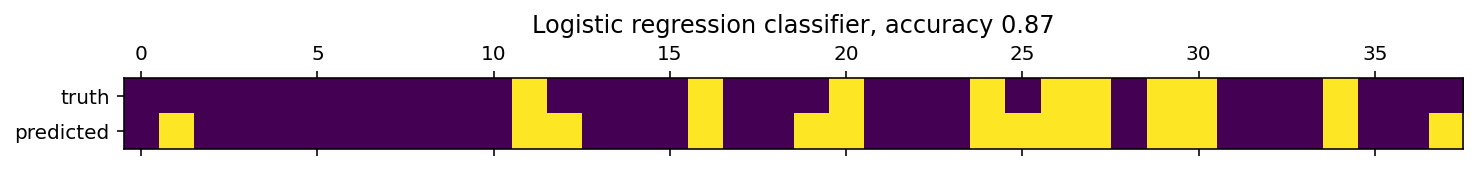

In [260]:
raw_preds = sigma(np.dot(X_test, theta)) 
y_preds = (raw_preds > 0.5).astype(int)

fig,ax = plt.subplots(figsize=(12,6))
ax.matshow([y_test[0:50], y_preds[0:50]])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = 'truth'
labels[2] = 'predicted'
ax.set_yticklabels(labels);
ax.set_title('Logistic regression classifier, accuracy %.2f' % (accuracy_score(y_preds, y_test)));

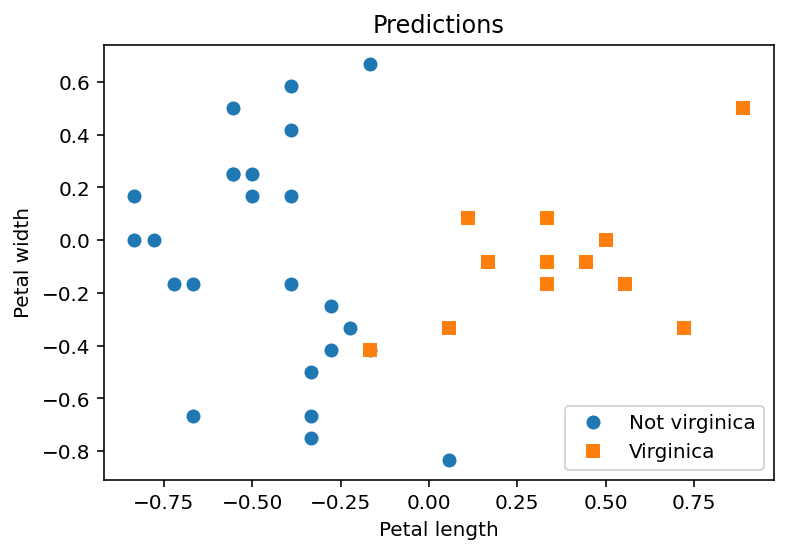

In [261]:
plt.plot(X_test[:,0][np.argwhere(y_preds == 0)[:,0]], X_test[:,1][np.argwhere(y_preds == 0)[:,0]], 'o', label='Not virginica')
plt.plot(X_test[:,0][np.argwhere(y_preds == 1)[:,0]], X_test[:,1][np.argwhere(y_preds == 1)[:,0]], 's', label='Virginica')
plt.title('Predictions')
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.legend(loc='best')

### 2 Softmax regression

The algorithm above can be quite easily adapted for multiclass classification, without the need to train multiple binary classification models. We reuse most of the same code, except that we're now trying to predict all three classes of the original iris dataset.

Here are the main modifications to the numerical implementation, which I'll annotate in the source code. 

1. Our target variable $y$ is no longer a $1\times 1$ matrix, but $1\times n$, where $n$ is the number of classes.

2. In the classical logistic regression implementation our weight matrix is a vector of size equal to the number of features

$$ \theta = \begin{bmatrix} \theta_1 & \cdots \theta_k \end{bmatrix} $$

3. But in softmax regression we are extending this to a weight matrix with one row for each possible class. 

$$ \theta = \begin{bmatrix} \theta_1^{a} & \cdots & \theta_k^b \\ \theta_1^{a} & \cdots & \theta_k^b \\ \cdots & \cdots & \cdots \\ \theta_1^{a} & \cdots & \theta_k^b \end{bmatrix} $$

4. Classical logistic regression returns a single value $\sigma(\theta^T X)$. But in softmax regression the corresponding operation returns a vector, one for each class -- that is, the same shape as the target variable $y$.

5. Once we have a score vector, we then transform it into a probability score by the softmax function

$$ \hat p_k = {\exp(s_k) \over \sum_i^K \exp (s_i)} $$

6. Again, this transformed probability vector has as many elements as there are unique classes. Then the predicted class is the row number for which the probability is highest.

In [267]:
def onehot(y, n):
  one_hot = np.zeros((len(y), n))
  one_hot[np.arange(len(y)), y] = 1
  return one_hot

In [393]:
data = datasets.load_iris()
selected_data = MinMaxScaler(feature_range=(-1,1)).fit_transform(data.data)
X_train, X_test, y_train, y_test = train_test_split(selected_data, data.target)
y_test_orig = y_test

# Point 1
y_train = onehot(y_train, 3)
y_test = onehot(y_test, 3)

num_features = X_train.shape[1]
m = X_train.shape[0]
theta = np.zeros((num_features, 3)) # Point 3


n = 500000    # Number of iterations of the gradient descent
eta = 0.05  # Learning rate
sigma = lambda t: 1 / (1+ np.exp(-t))

for i in range(n): # Point 4
    qq = sigma(theta.T.dot(X_train.T).T - y_train)
    dJdtheta = qq.T.dot(X_train).T
    theta = theta -  eta * dJdtheta

raw_preds = np.dot(X_test, theta)
raw_softmax = [np.exp(rp)/np.sum(np.exp(rp)) for rp in raw_preds] # Point 5
y_preds = [np.argmax(rs) for rs in raw_softmax] # Point 6



<ipython-input-395-b79c348c2b6b>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels);


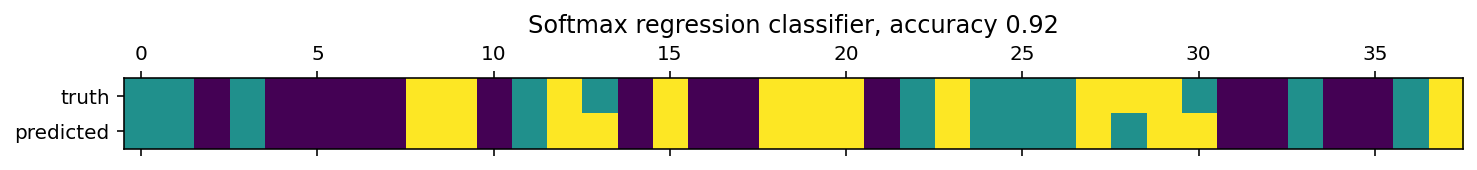

In [395]:
fig,ax = plt.subplots(figsize=(12,6))
ax.matshow([y_test_orig[0:50], y_preds[0:50]])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = 'truth'
labels[2] = 'predicted'
ax.set_yticklabels(labels);
ax.set_title('Softmax regression classifier, accuracy %.2f' % (accuracy_score(y_preds, y_test_orig)));

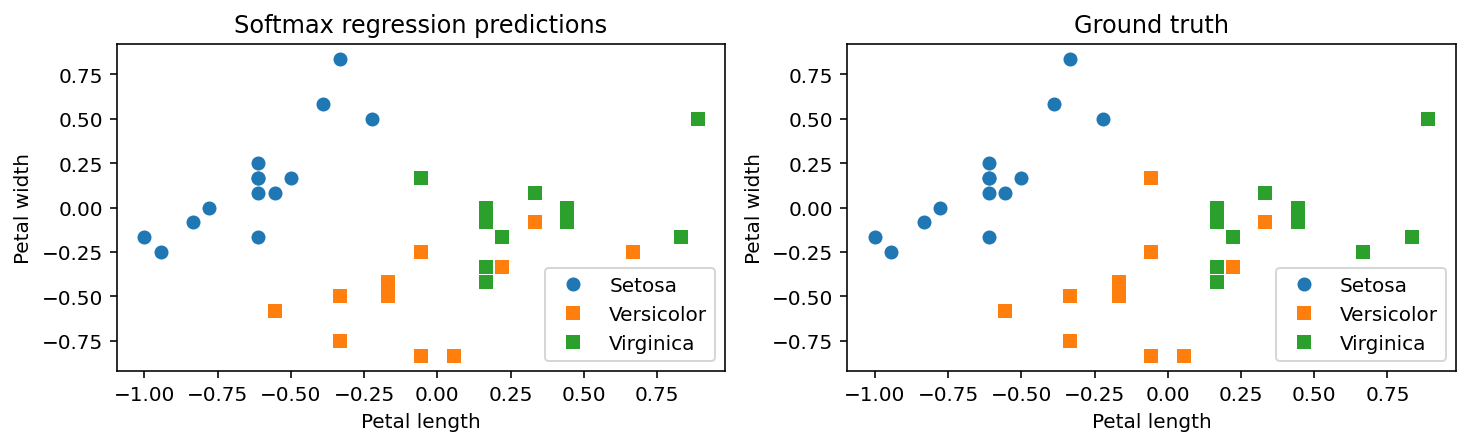

In [396]:
fig,(ax1,ax2) =plt.subplots(1,2,figsize=(12,3))
ax1.plot(X_test[:,0][np.argwhere(np.array(y_preds) == 0)], X_test[:,1][np.argwhere(np.array(y_preds) == 0)], 'o', label='Setosa')
ax1.plot(X_test[:,0][np.argwhere(np.array(y_preds) == 1)], X_test[:,1][np.argwhere(np.array(y_preds) == 1)], 's', label='Versicolor')
ax1.plot(X_test[:,0][np.argwhere(np.array(y_preds) == 2)], X_test[:,1][np.argwhere(np.array(y_preds) == 2)], 's', label='Virginica')

ax2.plot(X_test[:,0][np.argwhere(np.array(y_test_orig) == 0)], X_test[:,1][np.argwhere(np.array(y_test_orig) == 0)], 'o', label='Setosa')
ax2.plot(X_test[:,0][np.argwhere(np.array(y_test_orig) == 1)], X_test[:,1][np.argwhere(np.array(y_test_orig) == 1)], 's', label='Versicolor')
ax2.plot(X_test[:,0][np.argwhere(np.array(y_test_orig) == 2)], X_test[:,1][np.argwhere(np.array(y_test_orig) == 2)], 's', label='Virginica')

ax1.set_title('Softmax regression predictions')
ax1.set_xlabel('Petal length')
ax1.set_ylabel('Petal width')
ax1.legend(loc='best')

ax2.set_title('Ground truth')
ax2.set_xlabel('Petal length')
ax2.set_ylabel('Petal width')
ax2.legend(loc='best')

The softmax regressor needs quite a bit more training iterations to achieve a good accuracy, but the upside is that we don't have to train multiple binary classifiers. 